In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
from threading import *

In [2]:
# процент пикселов, в которых будут изменения (размер сообщения)

def count_of_change(image, percent):
    pix_count_1 = image.shape[0]
    pix_count_2 = image.shape[1]
    pix_all = pix_count_1*pix_count_2
    return round(pix_all/100)*percent

In [3]:
# Заданное количество пикселов сообщения нужно разместить среди всех пикселов исходного изображения.
# Генерируем случайные числа - ключ для кодирования и декодирования

def generate_location(image, message_size):
    image_size = image.size
    location = np.random.permutation(np.arange(0, image_size))[:message_size]
    return location

In [4]:
# в нашем случае сообщение - равномерный белый шум
def encode1 (image, location):
    img_flatten = image.flatten()
     
        
    # находим пикселы по ключу
    for k in location:
        a = img_flatten[k]

        # строковое представление числа в двоичной системе
        a = np.binary_repr(a, width=8)
        
        
        # заменяем младший бит
        noise = '1' if a[-1] == '0' else '0'
        new =  a[:-1] + noise
        
        
        # записываем в формате uint8
        new = (int(new, 2))
        
        img_flatten[k] = new
    
    
    img_new = np.reshape(img_flatten, image.shape)    
    return img_new    

In [5]:
# В качестве вектора признаков возьмем набор длин серий от 1 до 10. 
# Серия - последовательность младших бит, состоящая из одинаковых элементов (0 или 1)
# У пустых контейнеров количество таких серий ожидается больше начиная с длины 5-6

def img_series(image):
    img_flatten = image.flatten()

    # все переводим в двоичную и записываем в одну строку
    res = ''
    for a in img_flatten:
        a = np.binary_repr(a, width=8)
        res = res + a[7]

    # количество одинаковых чисел
    ch_count = 1
    
    # список длин цепочек одинаковых чисел
    list_of_series_length = []
    
    for ch in range(len(res) - 1):
        if res[ch] == res[ch + 1]:
            ch_count += 1
        else:
            list_of_series_length.append(ch_count)
            ch_count = 1
            
    list_of_series_length.append(ch_count)
    
    # считаем количество, сортируем
    dict_series = {}
    for series in list_of_series_length:
        flag = dict_series.get(series)
        if flag == None:
            dict_series[series] = 1
        else:
            dict_series[series] += 1
    
    dict_series_new = {k: v for k, v in dict_series.items() if k < 11}
    
    dict_series_sort = dict(sorted(dict_series_new.items(), key = itemgetter(1), reverse = True))
  
    return (dict_series_sort)

In [8]:
# продемонстрируем для одного изображения

# считали изображение
#img = cv2.imread('D:/Data_win/oboi/img1.akspic.ru-anime-anime_devushka_s_mashinoj-legkovyye_avtomobili-anime_art-shina-2048x1152.jpg', 0)
img = cv2.imread('./BOWS2/Image00001.tif',0)

percent = 30


pixel_change = count_of_change(img, percent)

location = generate_location(img, pixel_change)


img_with_massage = encode1(img, location)
img_difference = img_with_massage - img


print(img_series(img))
print(img_series(img_with_massage))

{1: 62397, 2: 31528, 3: 15918, 4: 8202, 5: 4375, 6: 2224, 7: 1114, 8: 637, 9: 369, 10: 180}
{1: 64920, 2: 32218, 3: 16293, 4: 8327, 5: 4153, 6: 2103, 7: 1066, 8: 564, 9: 245, 10: 133}


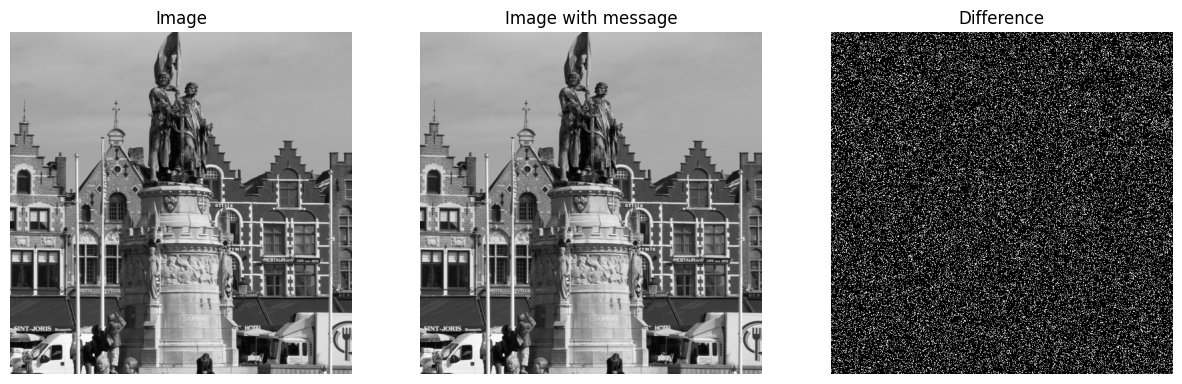

In [9]:
plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Image')
plt.imshow(img, cmap='gray')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Image with message')
plt.imshow(img_with_massage, cmap='gray')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Difference')
plt.imshow(img_difference, cmap='gray')

plt.show()

In [10]:
def create_dataset (percent, dir_name):
    # создаем пустой датасет
    df_title = {'Image Name': [], 'series length 1': [], 
                'series length 2': [], 'series length 3': [],'series length 4': [],
                'series length 5': [], 'series length 6': [], 'series length 7': [],
                'series length 8': [], 'series length 9': [], 'series length 10': [],
                'with message': []}

    df = pd.DataFrame(df_title)

    # имя новой папки
    new_dir_name = 'Data' + str(percent) + '/'
    if os.path.exists(new_dir_name) == False:
        os.mkdir(new_dir_name)

    
    # в первые 50% зашифровываем сообщение, считаем длины серий. Метка "with message" = 1
    pictures = os.listdir(dir_name)
    len_1 = len(pictures) // 2
    
    list_df1 = []

    for k in range(len_1):
        im = cv2.imread(f'{dir_name}{pictures[k]}', 0)
        if type(im) == np.ndarray:
            # процент занимаемый сообщением
            pixel_change = count_of_change(im, percent)
            # местоположение сообщения на изображении
            location = generate_location(im, pixel_change)
            # кодируем сообщение
            img_with_massage = encode1(im, location)
        
            list_series1 = img_series(img_with_massage)
            #print(list_df1)
            list_df1.append({'Image Name': pictures[k], 
                        'series length 1': list_series1[1],'series length 2': list_series1[2],
                        'series length 3': list_series1[3],'series length 4': list_series1[4],
                        'series length 5': list_series1[5],'series length 6': list_series1[6],
                        'series length 7': list_series1[7],'series length 8': list_series1[8],
                        'series length 9': list_series1[9],'series length 10': list_series1[10],
                        'with message': 1})

            # сохраняем измененное в новую папку
            cv2.imwrite(f'{new_dir_name}{pictures[k]}', img_with_massage)
    
    
    # для оставшихся 50% считаем длины серий. Метка "with message" = 0
    list_df2 = []
    for k in range(len_1, len(pictures)):
        im = cv2.imread(f'{dir_name}{pictures[k]}', 0)
        if type(im) == np.ndarray:
            list_series2 = img_series(im)
            list_df2.append({'Image Name': pictures[k],
                        'series length 1': list_series2[1],'series length 2': list_series2[2],
                        'series length 3': list_series2[3],'series length 4': list_series2[4],
                        'series length 5': list_series2[5],'series length 6': list_series2[6],
                        'series length 7': list_series2[7],'series length 8': list_series2[8],
                        'series length 9': list_series2[9],'series length 10': list_series2[10],
                        'with message': 0})
            
            # сохраняем измененное в новую папку
            cv2.imwrite(f'{new_dir_name}{pictures[k]}', im)
    
    df = df.append(list_df1)
    df = df.append(list_df2)
    # сохраняем
    df.to_csv('LSB_'+str(percent)+'.csv', index=False)
    #return df

In [ ]:
df2 = create_dataset (70, './BOWS2/')
# сохраняем
df2.to_csv('LSB_70.csv', index=False)